Baseline Evaluation for Weather Data

- Done via an ARIMA model with HPO CV

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima.arima import ARIMA
from pmdarima.model_selection import SlidingWindowForecastCV
import optuna

In [2]:
import sys
import pandas as pd
import numpy as np
import pmdarima
import statsmodels as sm
import sklearn
import optuna

print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("pmdarima:", pmdarima.__version__)
print("statsmodels:", sm.__version__)
print("scikit-learn:", sklearn.__version__)
print("optuna:", optuna.__version__)


Python: 3.12.1
pandas: 2.3.0
numpy: 1.26.4
pmdarima: 2.0.4
statsmodels: 0.14.4
scikit-learn: 1.7.0
optuna: 4.3.0


Read in & Preprocess data

In [28]:
# Read in data
years = ["2024"]
columns = ["ISO Time", "Temperature (C)", "Humidity (%)", "Pressure (kPa)", "Air Quality (Ohms)"]
all_data = pd.read_csv("../data/2023_BME680SensorData.csv", usecols=columns)

for year in years:
    data_filename = f"../data/{year}_BME680SensorData.csv"
    read_in_data = pd.read_csv(data_filename, usecols=columns)
    all_data = pd.concat([all_data, read_in_data], ignore_index=True)

print("Data Collected")
all_data.head()

all_data["ISO Time"] = pd.to_datetime(all_data["ISO Time"])
all_data.set_index("ISO Time", inplace=True)
hourly_avg = all_data.resample("H").mean()

# Nat: Fill any NaN as the average of the immediately preceding and following values
hourly_avg = hourly_avg.apply(
    lambda s: s.where(s.notna(), (s.shift(1) + s.shift(-1)) / 2)
)
# If there are still NaNs at the very start or end, forward/backward-fill them:
hourly_avg = hourly_avg.ffill().bfill()

print("Hourly-averaged preview & missing check")
print(hourly_avg.head(), "\n")

Data Collected
Hourly-averaged preview & missing check
                     Temperature (C)  Humidity (%)  Pressure (kPa)  \
ISO Time                                                             
2023-01-01 00:00:00        16.246780     65.636780      100.392271   
2023-01-01 01:00:00        16.207143     62.458214      100.421446   
2023-01-01 02:00:00        16.215254     60.416780      100.428881   
2023-01-01 03:00:00        16.012833     60.395333      100.426700   
2023-01-01 04:00:00        15.748305     61.038305      100.478898   

                     Air Quality (Ohms)  
ISO Time                                 
2023-01-01 00:00:00       319796.050847  
2023-01-01 01:00:00       380331.535714  
2023-01-01 02:00:00       456254.559322  
2023-01-01 03:00:00       502825.500000  
2023-01-01 04:00:00       517001.288136   



/var/folders/7r/8tzl4xz922146pgx3szt94t80000gn/T/ipykernel_60061/639003094.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_avg = all_data.resample("H").mean()


Plot Data

<Figure size 1400x500 with 0 Axes>

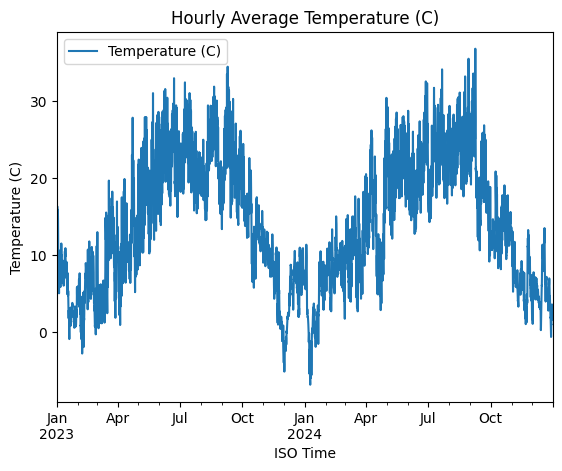

<Figure size 1400x500 with 0 Axes>

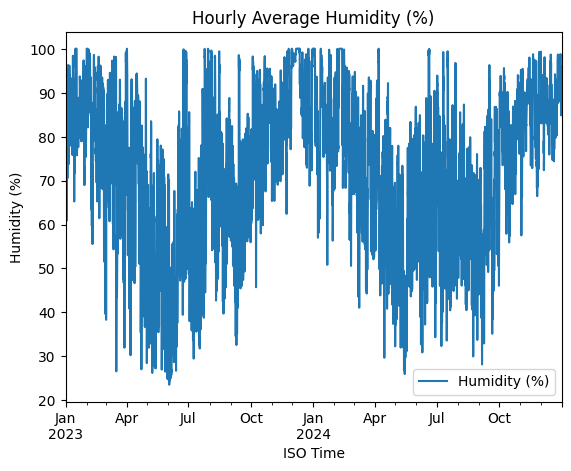

<Figure size 1400x500 with 0 Axes>

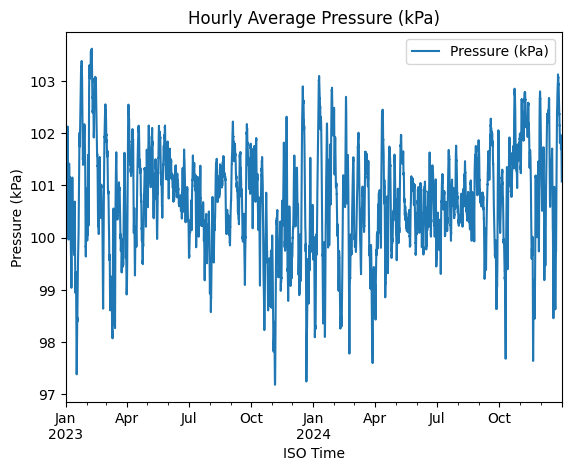

<Figure size 1400x500 with 0 Axes>

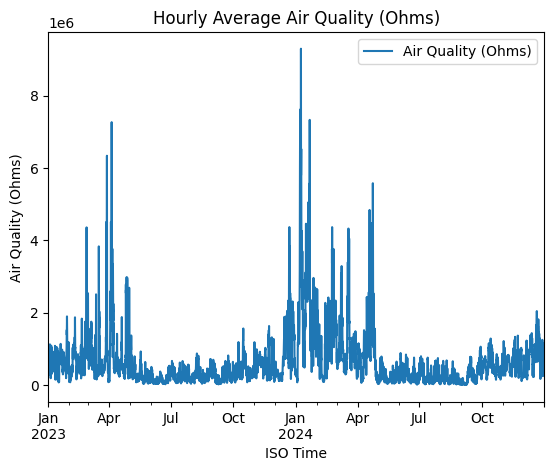

In [8]:
var_names = columns[1:]

for variable in var_names:
    plt.figure(figsize=(14, 5))
    hourly_avg.plot(y=variable)
    plt.title(f"Hourly Average {variable}")
    plt.ylabel(variable)
    plt.show()

In [ ]:
# Data exploration - replacing NaNs with averages did not change much:
orig = hourly_avg["Temperature (C)"].to_numpy()

clean = hourly_avg["Temperature (C)"].dropna().to_numpy()

# print sizes
print(f"Size with NaNs:    {orig.size}")
print(f"Size without NaNs: {clean.size}")

Size with NaNs:    17544
Size without NaNs: 17544


In [14]:
train_data = hourly_avg["Temperature (C)"].dropna().to_numpy()

look_back = 168  # 7 days
horizon = 24     # 1 day

CV HPO

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_absolute_scaled_error(y_true, y_pred, insample):
    """ MASE using naive forecast as denominator (seasonality=1 assumed) """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    insample = np.array(insample)
    naive_forecast = np.abs(insample[1:] - insample[:-1])
    denom = np.mean(naive_forecast)
    return np.mean(np.abs(y_true - y_pred)) / denom

def objective(trial):
    p = trial.suggest_int('p', 0, 3)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 3)

    try:
        cv = SlidingWindowForecastCV(
            window_size=look_back,
            step=24,
            h=horizon,
            # Nat: increased k in k-fold CV up to 10 
            initial=train_data.shape[0] - look_back - 10*horizon
        )
        scores = []
        for y_train_cv, y_test_cv in cv.split(train_data):
            model = ARIMA(order=(p, d, q))
            model.fit(y_train_cv)
            y_pred_cv = model.predict(n_periods=len(y_test_cv))
            score = root_mean_squared_error(y_test_cv, y_pred_cv)
            scores.append(score)
        return np.mean(scores)
    except Exception as e:
        return float('inf')

In [ ]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner()
)
# Nat: increased the number of trials and timeout
study.optimize(objective, n_trials=100, timeout=1800)
print("Best params:", study.best_params)

[I 2025-06-15 22:21:02,364] A new study created in memory with name: no-name-3500ee6b-3101-4a98-acbc-92fabece2415
[I 2025-06-15 22:21:02,373] Trial 0 finished with value: inf and parameters: {'p': 1, 'd': 1, 'q': 2}. Best is trial 0 with value: inf.
[I 2025-06-15 22:21:02,374] Trial 1 finished with value: inf and parameters: {'p': 0, 'd': 2, 'q': 3}. Best is trial 0 with value: inf.
[I 2025-06-15 22:21:02,375] Trial 2 finished with value: inf and parameters: {'p': 2, 'd': 1, 'q': 0}. Best is trial 0 with value: inf.
[I 2025-06-15 22:21:02,375] Trial 3 finished with value: inf and parameters: {'p': 2, 'd': 2, 'q': 3}. Best is trial 0 with value: inf.
[I 2025-06-15 22:21:02,376] Trial 4 finished with value: inf and parameters: {'p': 0, 'd': 1, 'q': 2}. Best is trial 0 with value: inf.
[I 2025-06-15 22:21:02,376] Trial 5 finished with value: inf and parameters: {'p': 3, 'd': 1, 'q': 1}. Best is trial 0 with value: inf.
[I 2025-06-15 22:21:02,377] Trial 6 finished with value: inf and param

Best params: {'p': 1, 'd': 1, 'q': 2}


Test Data

In [19]:
test_data = pd.read_csv("../data/2025_BME680SensorData.csv", usecols=columns)
test_data["ISO Time"] = pd.to_datetime(test_data["ISO Time"])
test_data["Date"] = test_data["ISO Time"].dt.date
test_data["Hour"] = test_data["ISO Time"].dt.hour
hourly_avg_test = test_data.groupby(["Date", "Hour"]).mean()
hourly_avg_test

time_index = hourly_avg_test.index.to_series().sort_values().reset_index(drop=True)
test_data = hourly_avg_test["Temperature (C)"]

# Reset the index so you can combine Date and Hour into a single datetime column
test_data = test_data.reset_index()
test_data['datetime'] = pd.to_datetime(test_data['Date']) + pd.to_timedelta(test_data['Hour'], unit='h')
test_data = test_data.set_index('datetime')
test_data.drop(columns=["Date", "Hour"], inplace=True)
test_data["Temperature (C)"] = test_data["Temperature (C)"].astype(np.float32)
test_data = test_data.to_numpy().reshape(-1,)
test_data[-32*24 - 10]

11.514545

Best Model

In [20]:
best_params = study.best_trial.params
model = ARIMA(order=(best_params['p'], best_params['d'], best_params['q']), suppress_warnings=True)
model.fit(train_data)
y_pred = model.predict(n_periods=len(test_data))

print("MAPE:", mean_absolute_percentage_error(test_data, y_pred))
print("RMSE:", root_mean_squared_error(test_data, y_pred))
print("MASE:", mean_absolute_scaled_error(test_data, y_pred, train_data))

/Users/nataliiaremezova/Documents/Workspace/BHT/SoSe2025/DSApps2/project/BerlinWeatherTimeSeriesAnalysis/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MAPE: 183.6982051119485
RMSE: 11.956639771374876
MASE: 22.701739909279436


/Users/nataliiaremezova/Documents/Workspace/BHT/SoSe2025/DSApps2/project/BerlinWeatherTimeSeriesAnalysis/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Plots

/var/folders/7r/8tzl4xz922146pgx3szt94t80000gn/T/ipykernel_60061/2765477906.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start=start_time, periods=len(test_data), freq="H")


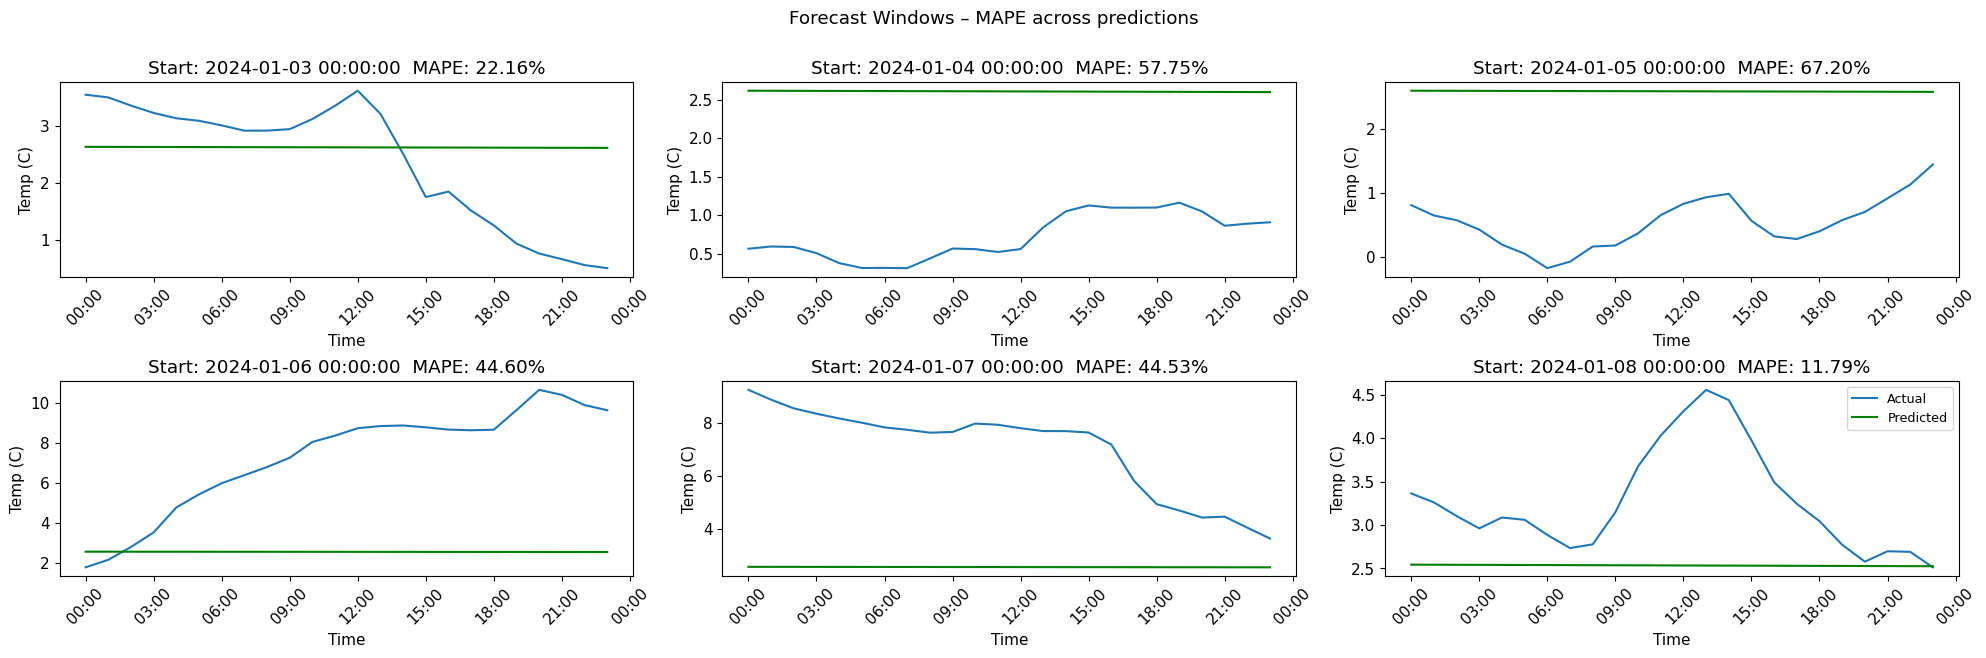

In [23]:
horizon = 24        # Number of time steps per forecast
offset = 2          # Starting forecast block
numplots = 6        # How many forecast windows to plot
start_time = pd.Timestamp("2024-01-01 00:00")  # Adjust as needed
time_index = pd.date_range(start=start_time, periods=len(test_data), freq="H")

plt.figure(figsize=(20, 9))
plt.rcParams.update({'font.size': 11})
date_formater = mdates.DateFormatter('%H:%M')

for idx in range(numplots):
    t_idx = offset + idx
    start = t_idx * horizon
    end = start + horizon
    if end > len(test_data):
        break
    

    actual_window = test_data[start:end]
    pred_window = y_pred[start:end]
    time_window = time_index[start:end]

    smape = np.mean(np.abs(actual_window - pred_window) / (np.abs(actual_window) + np.abs(pred_window))) * 100

    ax = plt.subplot(3, 3, idx + 1)
    ax.set_title(f"Start: {time_window[0]}  MAPE: {smape:.2f}%")
    ax.plot(time_window, actual_window, label="Actual")
    ax.plot(time_window, pred_window, label="Predicted", color='g')
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_xlabel('Time')
    ax.set_ylabel('Temp (C)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Forecast Windows – MAPE across predictions")
plt.legend(fontsize="small")
plt.show()

# Predict-The-Mean Baseline

No Hyperparameter tuning, just take the mean of the training data, compare that against the test, and do plots.

"Train" the model

In [80]:
model = np.mean(train_data)
model

13.683992623163176

Compute Metrics

In [74]:
y_pred = model * np.ones_like(test_data)

print("MAPE:", mean_absolute_percentage_error(test_data, y_pred))
print("RMSE:", root_mean_squared_error(test_data, y_pred))
print("MASE:", mean_absolute_scaled_error(test_data, y_pred, train_data))

MAPE: 866.755485534668
RMSE: 7.522595002882488
MASE: 14.646165401799582


Plot (Cold Time)

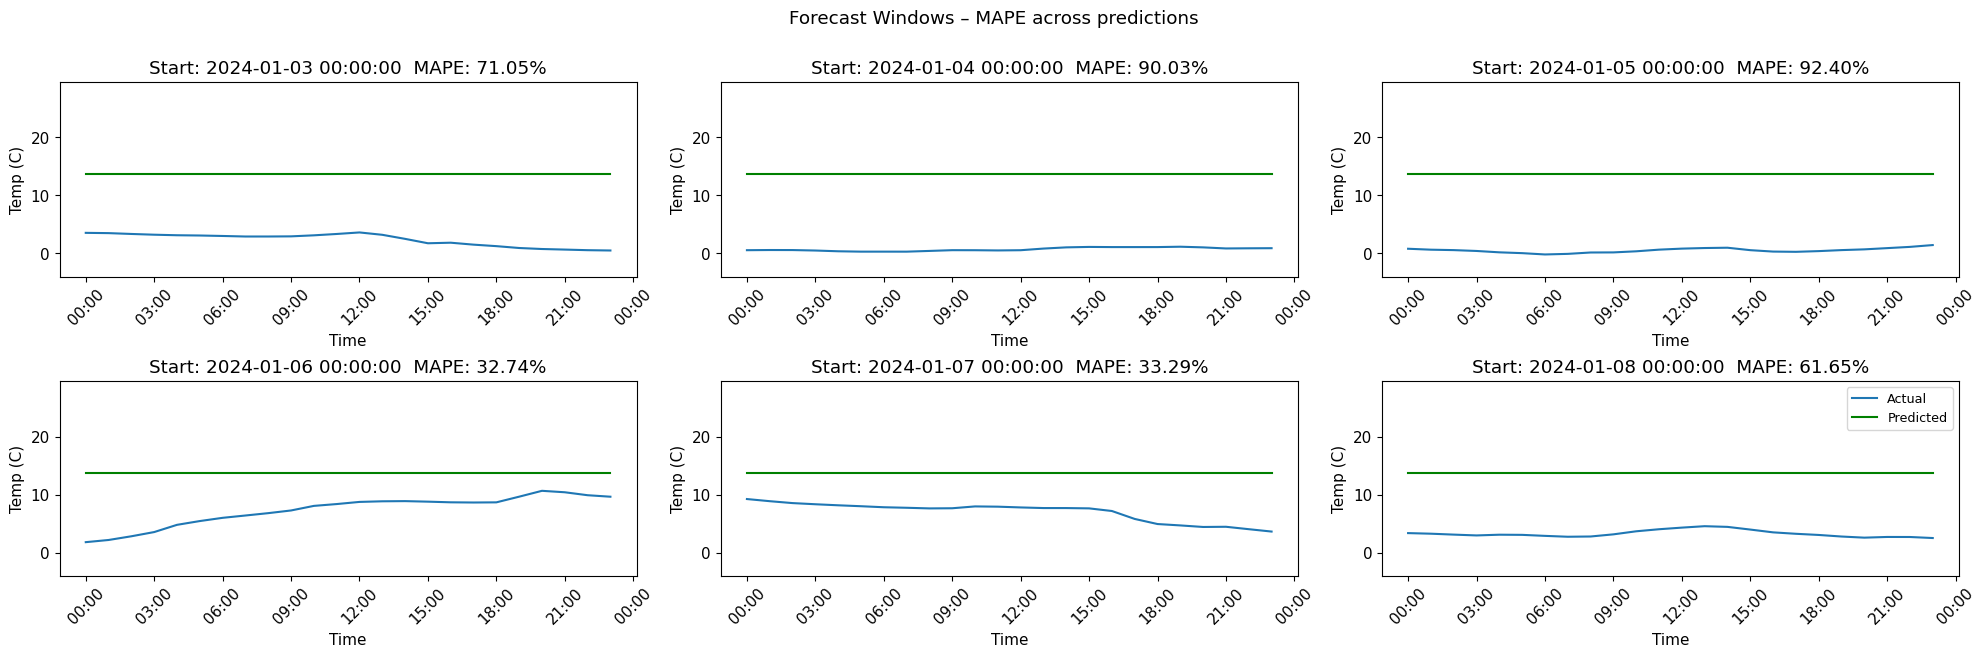

In [77]:
horizon = 24        # Number of time steps per forecast
offset = 2          # Starting forecast block
numplots = 6        # How many forecast windows to plot
start_time = pd.Timestamp("2024-01-01 00:00")  # Adjust as needed
time_index = pd.date_range(start=start_time, periods=len(test_data), freq="H")
y_min = min(test_data.min(), y_pred.min())
y_max = max(test_data.max(), y_pred.max())


plt.figure(figsize=(20, 9))
plt.rcParams.update({'font.size': 11})
date_formater = mdates.DateFormatter('%H:%M')

for idx in range(numplots):
    t_idx = offset + idx
    start = t_idx * horizon
    end = start + horizon
    if end > len(test_data):
        break
    

    actual_window = test_data[start:end]
    pred_window = y_pred[start:end]
    time_window = time_index[start:end]

    smape = np.mean(np.abs(actual_window - pred_window) / (np.abs(actual_window) + np.abs(pred_window))) * 100

    ax = plt.subplot(3, 3, idx + 1)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"Start: {time_window[0]}  MAPE: {smape:.2f}%")
    ax.plot(time_window, actual_window, label="Actual")
    ax.plot(time_window, pred_window, label="Predicted", color='g')
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_xlabel('Time')
    ax.set_ylabel('Temp (C)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Forecast Windows – MAPE across predictions")
plt.legend(fontsize="small")
plt.show()

Plot (Warm Time)

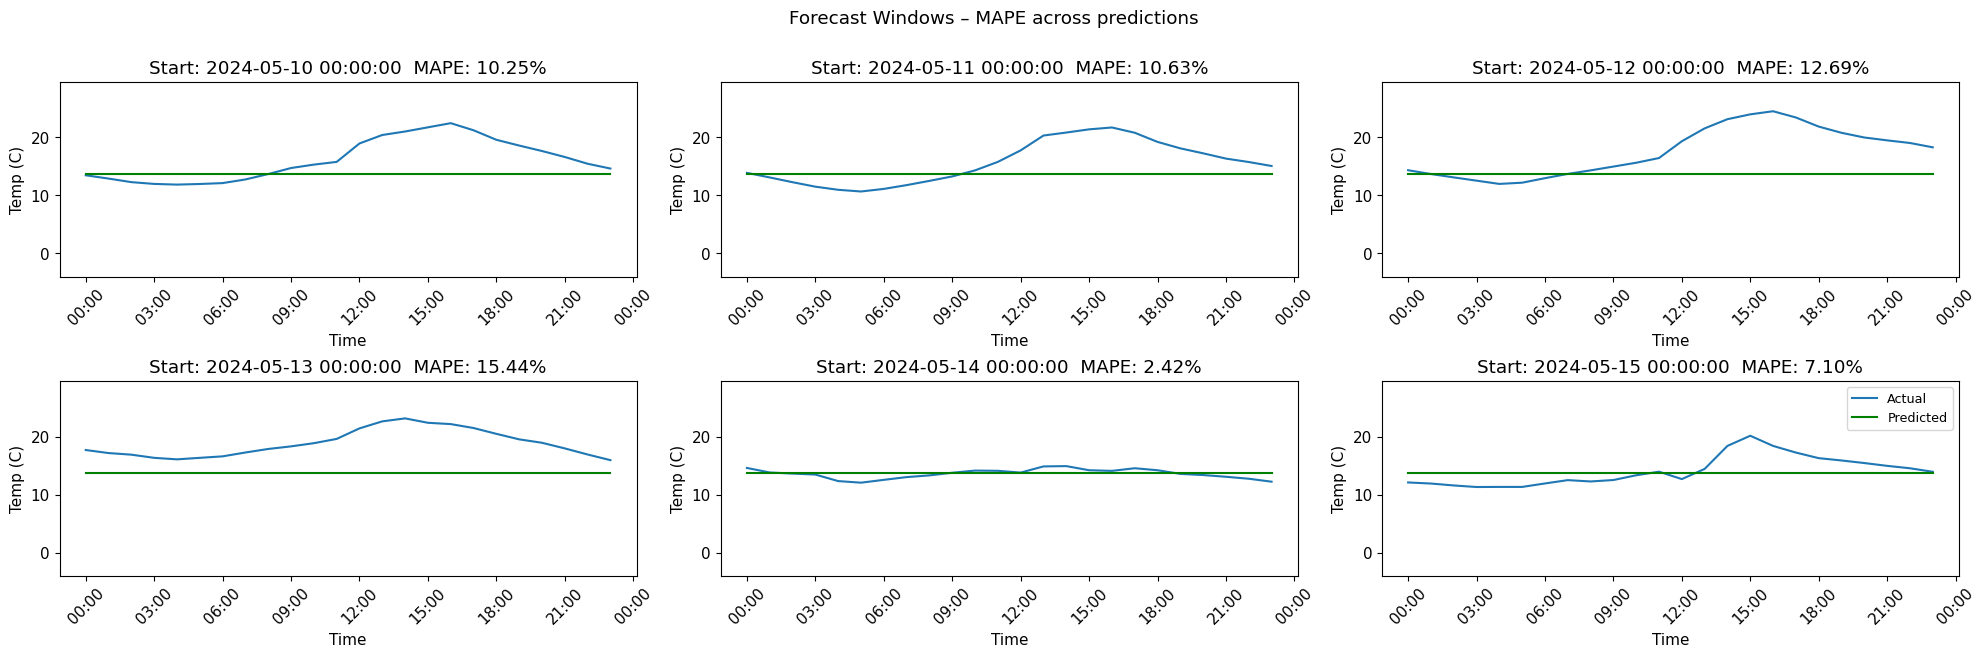

In [78]:
horizon = 24        # Number of time steps per forecast
offset = 130          # Starting forecast block
numplots = 6        # How many forecast windows to plot
start_time = pd.Timestamp("2024-01-01 00:00")  # Adjust as needed
time_index = pd.date_range(start=start_time, periods=len(test_data), freq="H")


plt.figure(figsize=(20, 9))
plt.rcParams.update({'font.size': 11})
date_formater = mdates.DateFormatter('%H:%M')

for idx in range(numplots):
    t_idx = offset + idx
    start = t_idx * horizon
    end = start + horizon
    if end > len(test_data):
        break
    

    actual_window = test_data[start:end]
    pred_window = y_pred[start:end]
    time_window = time_index[start:end]

    smape = np.mean(np.abs(actual_window - pred_window) / (np.abs(actual_window) + np.abs(pred_window))) * 100

    ax = plt.subplot(3, 3, idx + 1)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"Start: {time_window[0]}  MAPE: {smape:.2f}%")
    ax.plot(time_window, actual_window, label="Actual")
    ax.plot(time_window, pred_window, label="Predicted", color='g')
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_xlabel('Time')
    ax.set_ylabel('Temp (C)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Forecast Windows – MAPE across predictions")
plt.legend(fontsize="small")
plt.show()